In [240]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import mlflow.tensorflow
import tensorflow_addons as tfa

### load dataset from directory

In [241]:
mlflow.tensorflow.autolog()

batch_size = 32

IMG_SIZE = (224, 224)

train_dir = 'data/images/cls_2/train'
val_dir = 'data/images/cls_2/val'
#train_dir = 'data/images_balanced/train'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  shuffle = False,
  image_size=IMG_SIZE,
  batch_size=None)

img, lbl = tuple(zip(*train_ds))

file_paths = train_ds.file_paths
y_patient = ['_'.join(x.split('/')[-1].split('_')[0:2]) for x in file_paths] # -> 0_f1
file_tensor = tf.convert_to_tensor(y_patient)

indices = tf.range(start=0, limit=tf.shape(lbl)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed = 8)

shuffled_x = tf.gather(img, shuffled_indices)
shuffled_y = tf.gather(lbl, shuffled_indices)
files_train = tf.gather(y_patient, shuffled_indices)

ds_train = tf.data.Dataset.from_tensor_slices((shuffled_x,shuffled_y))
ds_train = ds_train.batch(batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  validation_split=None,
  shuffle = False,
  image_size=IMG_SIZE,
  batch_size=None)

img, lbl = tuple(zip(*val_ds))

file_paths = val_ds.file_paths
y_patient = ['_'.join(x.split('/')[-1].split('_')[0:2]) for x in file_paths] # -> 0_f1
file_tensor = tf.convert_to_tensor(y_patient)

indices = tf.range(start=0, limit=tf.shape(lbl)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices, seed = 8)

shuffled_x = tf.gather(img, shuffled_indices)
shuffled_y = tf.gather(lbl, shuffled_indices)
files_val = tf.gather(y_patient, shuffled_indices)

ds_val = tf.data.Dataset.from_tensor_slices((shuffled_x,shuffled_y))
ds_val = ds_val.batch(batch_size=batch_size)

Found 2948 files belonging to 2 classes.
Found 950 files belonging to 2 classes.


In [242]:
def random_level(x, upper = 0.2):
    """lower the level of the spectrogram by random amount between 0 and 0.2 

    Args:
        x (_type_): _description_

    Returns:
        _type_: _description_
    """
    return tf.random.uniform(shape = (), minval = 1 - upper, maxval=1) * x

In [243]:
def random_time_mask(x, lower = 0, upper = 0.5):
    """randomly apply time mask on image

    Args:
        x (tensorflow tensor): A iamge of shape (height, width, channels)
        lower (int, optional): upper limit of mask size ratio compared to image size. 0 means no masking. Defaults to 0.
        upper (float, optional): upper limit of mask size ratio compared to image size. Defaults to 0.5.

    Returns:
        _type_: _description_
    """
    length = x.shape[0]
    lower = lower / 2
    upper = upper / 2
    x = tf.expand_dims(x, axis=0)
    x = tf.squeeze(tfa.image.random_cutout(x, (length,2 * tf.random.uniform(shape=(), minval=int(length * lower), maxval=int(length * upper), dtype=tf.int32))), axis = 0)
    return x

In [244]:
def random_freq_mask(x, lower = 0, upper = 0.5):
    """randomly apply frequency mask on image

    Args:
        x (tensorflow tensor): A image tensor of shape (height, width, channels)
        lower (int, optional): upper limit of mask size ratio compared to image size. 0 means no masking. Defaults to 0.
        upper (float, optional): upper limit of mask size ratio compared to image size. Defaults to 0.5.

    Returns:
        image
    """
    length = x.shape[0]
    lower = lower / 2
    upper = upper / 2
    x = tf.expand_dims(x, axis=0)
    x = tf.squeeze(tfa.image.random_cutout(x, (2 * tf.random.uniform(shape = (), minval = int(length * lower), maxval = int(length * upper), dtype = tf.int32), length)), axis = 0)
    return x

In [245]:
def data_augmentation(x,y):
  """data augmentation chain

  Args:
      x (tensor): image tensor
      y (tensor): label tensor

  Returns:
      image, label
  """
  #tf.keras.layers.RandomContrast((0.3,0.3), seed=42),
  x = random_level(x, upper = 0.1)
  for i in range(tf.random.uniform(shape = (), minval = 0, maxval= 2, dtype=tf.int32)):
    x = random_time_mask(x, lower = 0, upper = 0.2)
  for i in range(tf.random.uniform(shape = (), minval = 0, maxval= 2, dtype=tf.int32)):
    x = random_freq_mask(x, lower = 0, upper = 0.2)
  return x,y



In [246]:
def load_dataset(folder, batch_size = 32, training=True, image_size = (224, 224), rseed = 8):
    # We create a TensorFlow Dataset from the list of files.
    # This dataset does not load the data into memory, but instead
    # pulls batches one after another.
    dataset = tf.keras.utils.image_dataset_from_directory(
    folder,
    validation_split=None,
    shuffle = False,
    image_size=IMG_SIZE,
    batch_size=None)
    
    img, lbl = tuple(zip(*dataset))

    file_paths = dataset.file_paths
    y_patient = ['_'.join(x.split('/')[-1].split('_')[0:2]) for x in file_paths] # -> 0_f1
    file_tensor = tf.convert_to_tensor(y_patient)

    indices = tf.range(start=0, limit=tf.shape(lbl)[0], dtype=tf.int32)
    shuffled_indices = tf.random.shuffle(indices, seed = rseed)

    shuffled_x = tf.gather(img, shuffled_indices)
    shuffled_y = tf.gather(lbl, shuffled_indices)
    shuffled_files = tf.gather(y_patient, shuffled_indices)

    dataset = tf.data.Dataset.from_tensor_slices((shuffled_x,shuffled_y))

    if training:

        y_size = len(shuffled_y)
        weight_0 = np.sum(shuffled_y)/ y_size
        weight_1 = 1 - weight_0
        print(weight_0)
        class_weights = { 0 : 2 * weight_0 , 1 : 2.25 * weight_1}


        dataset = dataset.map(data_augmentation)
        #dataset = tf.data.Dataset.from_tensor_slices(dataset)
        dataset = dataset.\
            repeat(count=None) # Infinite iterations
    else: 
        # Evaluation or testing
        class_weights = None
        y_size = len(shuffled_y)
        dataset = dataset.\
            repeat(count=1) # One iteration
            
    # The dataset will produce batches of BATCH_SIZE and will
    # automatically prepare an optimized number of batches while the prior one is
    # trained on.
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE), shuffled_files, class_weights, y_size

In [247]:
mlflow.tensorflow.autolog()

batch_size = 32

IMG_SIZE = (224, 224)
train_dir = 'data/images/cls_2/train'
val_dir = 'data/images/cls_2/val'
ds_train, _, class_weights, train_size = load_dataset(train_dir, batch_size = 32, training=True, image_size = (224, 224), rseed = 8)
ds_val, val_files, _, _ = load_dataset(val_dir, batch_size = 32, training=False, image_size = (224, 224), rseed = 8)

Found 2948 files belonging to 2 classes.
0.3541383989145183
Found 950 files belonging to 2 classes.


### Image Preview

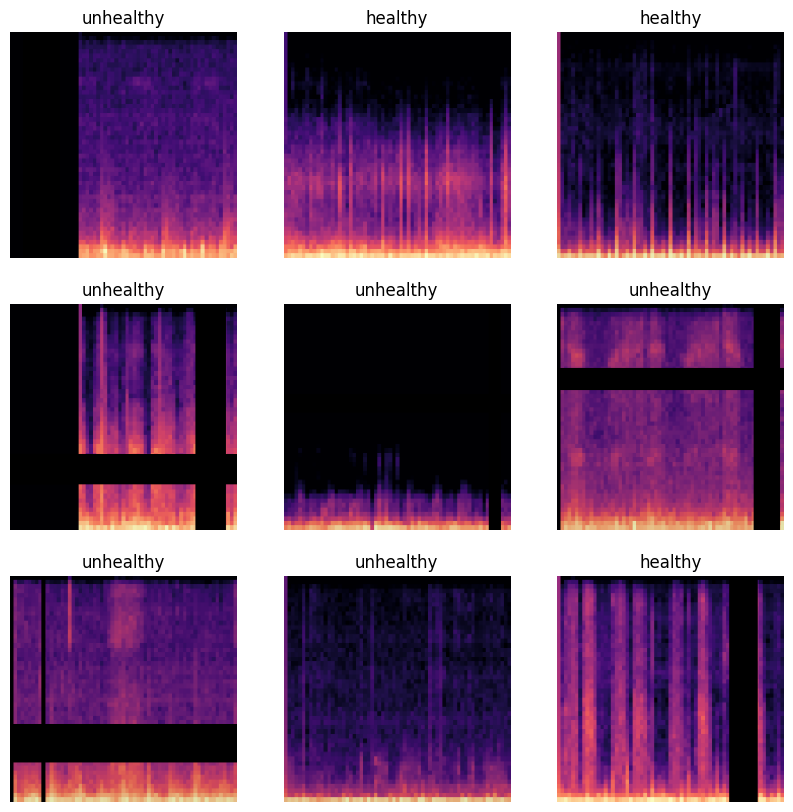

In [248]:
class_names = ['unhealthy', 'healthy']

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(5):
  labels = labels.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configure the dataset for performance

In [249]:

#use buffered prefetching, to yield data from disk without having I/O become blocking
train_ds = ds_train
val_ds = ds_val


### Data Augmentation

### Rescale pixel values

In [250]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

### Create the base model from the pre-trained ResNet50

In [251]:
# Create the base model from the pre-trained model ResNet50V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#### Freeze the convolutional base

### Basemodel summary

In [252]:
# Let's take a look at the base model architecture


base_model.trainable = False
# for layer in base_model.layers[:]:
#     layer.trainable = False
# # Let's take a look at the base model architecture
base_model.summary()    

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_23[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Add a classification head

In [253]:
# converts the features (output of base model) to a single 2048-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

### Add Dense Layer

In [254]:
#No activation Function needed because positive numbers predict class 1, negative numbers predict class 0
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

### Build a model

In [255]:
inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Early Stopping Callback

In [256]:
stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.000001,
    patience=3,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=False,
)

### Compile the model

In [257]:
#Compile the model before training it. Since there are two classes,
#use tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.
base_learning_rate = 0.00002

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=batch_size * 5,
    decay_rate=0.9,
    staircase = False)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
lr_metric = get_lr_metric(optimizer)


    
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', lr_metric])

In [258]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                          

### Train the model

In [259]:
initial_epochs = 30
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds, class_weight=class_weights, steps_per_epoch= train_size // batch_size, callbacks = [stopper])

2022/11/21 11:08:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '98e1abe6b4f04453bbd08c30be25ccc9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30


2022-11-21 11:08:30.472582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.4263 - lr: 1.9400e-05

2022-11-21 11:08:46.792586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 23s 199ms/step - loss: 0.7703 - accuracy: 0.4263 - lr: 1.9400e-05 - val_loss: 0.7023 - val_accuracy: 0.5242 - val_lr: 1.8824e-05
Epoch 2/30
92/92 [==============================] - 16s 173ms/step - loss: 0.7315 - accuracy: 0.4725 - lr: 1.8259e-05 - val_loss: 0.6738 - val_accuracy: 0.5884 - val_lr: 1.7718e-05
Epoch 3/30
92/92 [==============================] - 16s 173ms/step - loss: 0.7159 - accuracy: 0.5149 - lr: 1.7186e-05 - val_loss: 0.6581 - val_accuracy: 0.6232 - val_lr: 1.6676e-05
Epoch 4/30
92/92 [==============================] - 16s 173ms/step - loss: 0.7022 - accuracy: 0.5350 - lr: 1.6176e-05 - val_loss: 0.6480 - val_accuracy: 0.6432 - val_lr: 1.5696e-05
Epoch 5/30
92/92 [==============================] - 16s 173ms/step - loss: 0.6841 - accuracy: 0.5710 - lr: 1.5225e-05 - val_loss: 0.6391 - val_accuracy: 0.6579 - val_lr: 1.4773e-05
Epoch 6/30
92/92 [==============================] - 16s 173ms/step - loss: 0.6697 - accuracy: 0.5904 - lr:

2022-11-21 11:16:33.320822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022/11/21 11:16:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/mlflow/tensorflow/__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."


INFO:tensorflow:Assets written to: /var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/tmp5cjomoix/model/data/model/assets


2022/11/21 11:16:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/tmp5cjomoix/model, flavor: tensorflow), fall back to return ['tensorflow==2.8.0']. Set logging level to DEBUG to see the full traceback.


### Learning Curves

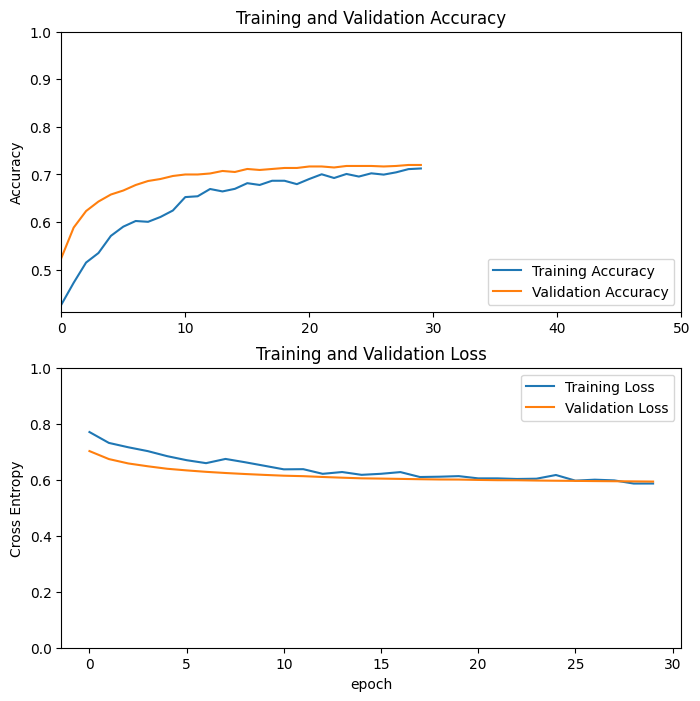

In [260]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlim(0,50)
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Note: If you are wondering why the validation metrics are clearly better than the training metrics,
#the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout
#affect accuracy during training. They are turned off when calculating validation loss.

In [261]:
y = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred = y_pred.squeeze(-1)
y_pred.shape
print(confusion_matrix(y, np.round(y_pred)))
print(classification_report(y, np.round(y_pred)))

2022-11-21 11:18:00.988993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[426 180]
 [ 86 258]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       606
           1       0.59      0.75      0.66       344

    accuracy                           0.72       950
   macro avg       0.71      0.73      0.71       950
weighted avg       0.74      0.72      0.73       950



In [266]:

names = val_files.numpy()

In [280]:

df = pd.DataFrame([names, y, y_pred], index = ['filename', 'y', 'y_pred']).T
df['y_pred_hard'] = df['y_pred'].astype(float).round()
df_patient = df.groupby('filename')['y','y_pred_hard'].agg(pd.Series.mean).round()
df.sort_values('filename')
df_patient

/var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/ipykernel_4158/1772873760.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_patient = df.groupby('filename')['y','y_pred_hard'].agg(pd.Series.mean).round()


,y,y_pred_hard
filename,,
b'0_f10',0.0,1.0
b'0_f15',0.0,0.0
b'0_f20',0.0,1.0
b'0_f21',0.0,1.0
b'0_f39',0.0,1.0
b'0_f52',0.0,1.0
b'0_f54',0.0,1.0
b'0_f56',0.0,1.0
b'0_f58',0.0,1.0


In [281]:
confusion_matrix(df_patient.y, df_patient.y_pred_hard)

array([[21, 15],
       [ 4,  8]])

In [282]:
print(classification_report(df_patient.y, df_patient.y_pred_hard))

              precision    recall  f1-score   support

         0.0       0.84      0.58      0.69        36
         1.0       0.35      0.67      0.46        12

    accuracy                           0.60        48
   macro avg       0.59      0.62      0.57        48
weighted avg       0.72      0.60      0.63        48



### Fine tuning

Read before you go on:

This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

In [87]:
# for layer in base_model.layers[:]:
#     layer.trainable = False


Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [289]:
base_model.trainable = True

lr_schedule_fine = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-7,
    decay_steps=batch_size * 5,
    decay_rate=0.9,
    staircase = False)

model_fine = model

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr

optimizer_fine = keras.optimizers.Adam(learning_rate=lr_schedule_fine)
lr_metric = get_lr_metric(optimizer_fine)


    
model_fine.compile(optimizer=optimizer_fine,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', lr_metric])

epochs = 10
history_fine = model_fine.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds, class_weight=class_weights, steps_per_epoch= train_size // batch_size)

2022/11/21 11:48:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4c085e8576bb45b88cae781bf516d8df', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10


2022-11-21 11:48:24.499318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.7901 - lr: 4.8500e-07

2022-11-21 11:49:08.696921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


92/92 [==============================] - 52s 466ms/step - loss: 0.4578 - accuracy: 0.7901 - lr: 4.8500e-07 - val_loss: 0.4734 - val_accuracy: 0.7621 - val_lr: 4.7061e-07
Epoch 2/10
92/92 [==============================] - 41s 441ms/step - loss: 0.4327 - accuracy: 0.7993 - lr: 4.5649e-07 - val_loss: 0.4588 - val_accuracy: 0.7726 - val_lr: 4.4294e-07
Epoch 3/10
92/92 [==============================] - 40s 436ms/step - loss: 0.4252 - accuracy: 0.8030 - lr: 4.2965e-07 - val_loss: 0.4504 - val_accuracy: 0.7747 - val_lr: 4.1691e-07
Epoch 4/10
92/92 [==============================] - 40s 435ms/step - loss: 0.4048 - accuracy: 0.8128 - lr: 4.0440e-07 - val_loss: 0.4433 - val_accuracy: 0.7842 - val_lr: 3.9240e-07
Epoch 5/10
92/92 [==============================] - 40s 433ms/step - loss: 0.3938 - accuracy: 0.8176 - lr: 3.8062e-07 - val_loss: 0.4343 - val_accuracy: 0.7874 - val_lr: 3.6933e-07
Epoch 6/10
92/92 [==============================] - 40s 434ms/step - loss: 0.3865 - accuracy: 0.8234 - lr:

2022-11-21 11:55:16.831071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022/11/21 11:55:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/louiskrause/neuefische/Respiratory_Disease_Classification/.venv/lib/python3.9/site-packages/mlflow/tensorflow/__init__.py:189: UserWarning: The pyfunc inference behavior of Keras models logged with signatures differs from the behavior of Keras models logged without signatures. Specifically, when a signature is present, passing a Pandas DataFrame as input to the pyfunc `predict()` API produces an `ndarray` (for single-output models) or a dictionary of `str -> ndarray`: (for multi-output models). In contrast, when a signature is *not* present, `predict()` produces a Pandas DataFrame output in response to a Pandas DataFrame input."


INFO:tensorflow:Assets written to: /var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/tmpy8dl3dgp/model/data/model/assets


2022/11/21 11:55:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/tmpy8dl3dgp/model, flavor: tensorflow), fall back to return ['tensorflow==2.8.0']. Set logging level to DEBUG to see the full traceback.


In [290]:
y = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred = y_pred.squeeze(-1)
y_pred.shape
print(confusion_matrix(y, np.round(y_pred)))
print(classification_report(y, np.round(y_pred)))

2022-11-21 11:55:44.728218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[470 136]
 [ 57 287]]
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       606
           1       0.68      0.83      0.75       344

    accuracy                           0.80       950
   macro avg       0.79      0.80      0.79       950
weighted avg       0.81      0.80      0.80       950



[[426 180]
 [ 86 258]]
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       606
           1       0.59      0.75      0.66       344

    accuracy                           0.72       950
   macro avg       0.71      0.73      0.71       950
weighted avg       0.74      0.72      0.73       950


In [291]:
model_fine.save("models/ResNet50_V2_1")

INFO:tensorflow:Assets written to: models/ResNet50_V2_1/assets
